### Data Dictionary

When selecting which stocks to invest in, investors seek to obtain good future returns. In this problem, we will first use clustering to identify clusters of stocks that have similar returns over time. Then, we'll use logistic regression to predict whether or not the stocks will have positive future returns.

For this problem, we'll use StocksCluster.csv, which contains monthly stock returns from the NASDAQ stock exchange. The NASDAQ is the second-largest stock exchange in the world, and it lists many technology companies. The stock price data used in this problem was obtained from infochimps, a website providing access to many datasets.

Each observation in the dataset is the monthly returns of a particular company in a particular year. The years included are 2000-2009. The companies are limited to tickers that were listed on the exchange for the entire period 2000-2009, and whose stock price never fell below $1. So, for example, one observation is for Yahoo in 2000, and another observation is for Yahoo in 2001. Our goal will be to predict whether or not the stock return in December will be positive, using the stock returns for the first 11 months of the year.

This dataset contains the following variables:

    ReturnJan = the return for the company's stock during January (in the year of the observation). 
    ReturnFeb = the return for the company's stock during February (in the year of the observation). 
    ReturnMar = the return for the company's stock during March (in the year of the observation). 
    ReturnApr = the return for the company's stock during April (in the year of the observation). 
    ReturnMay = the return for the company's stock during May (in the year of the observation). 
    ReturnJune = the return for the company's stock during June (in the year of the observation). 
    ReturnJuly = the return for the company's stock during July (in the year of the observation). 
    ReturnAug = the return for the company's stock during August (in the year of the observation). 
    ReturnSep = the return for the company's stock during September (in the year of the observation). 
    ReturnOct = the return for the company's stock during October (in the year of the observation). 
    ReturnNov = the return for the company's stock during November (in the year of the observation). 
    PositiveDec = whether or not the company's stock had a positive return in December (in the year of the observation). This variable takes value 1 if the return was positive, and value 0 if the return was not positive.

For the first 11 variables, the value stored is a proportional change in stock value during that month. For instance, a value of 0.05 means the stock increased in value 5% during the month, while a value of -0.02 means the stock decreased in value 2% during the month.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle
from pickle import dump, load

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("StocksCluster.csv")

In [3]:
df

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,PositiveDec
0,0.080678,0.066250,0.032941,0.183099,0.130334,-0.017642,-0.020517,0.024676,-0.020408,-0.173318,-0.025385,0
1,-0.010680,0.102115,0.145496,-0.084428,-0.327300,-0.359266,-0.025321,0.211290,-0.580003,-0.267141,-0.151235,0
2,0.047742,0.035990,0.039702,-0.162353,-0.147427,0.048589,-0.135385,0.033392,0.000000,0.091696,-0.059561,0
3,-0.074040,-0.048170,0.018219,-0.024679,-0.006036,-0.025304,-0.094000,0.095290,0.056680,-0.096339,-0.040512,1
4,-0.031046,-0.212677,0.091476,0.189338,-0.153846,-0.106115,0.355301,0.056842,0.033602,0.036269,-0.085305,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11575,-0.412598,-0.348853,0.080220,0.140919,0.264325,-0.202208,0.158703,0.270115,0.021023,-0.217680,-0.075896,0
11576,-0.153805,-0.140625,0.045124,0.318033,0.035736,0.134977,-0.056807,-0.029158,0.201563,-0.095903,0.263347,1
11577,-0.138686,-0.192090,0.229242,0.183735,0.232877,-0.029940,0.011213,-0.078140,0.141304,-0.153042,-0.004435,1
11578,-0.134111,-0.117148,0.705426,0.025229,0.258542,-0.011786,0.049180,-0.050687,0.034111,-0.226003,0.052995,1


In [4]:
df2 = df.sample(n=8995, random_state=0)

In [5]:
df2

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,PositiveDec
6116,0.201951,0.029964,-0.068128,0.007692,0.091371,-0.091163,0.027132,0.099716,0.033175,-0.029682,0.019313,0
9934,-0.021716,0.024457,-0.016784,0.010995,0.009305,-0.099837,0.036791,0.041740,-0.025112,-0.005193,0.002331,1
2917,0.043643,-0.099731,0.181721,-0.109940,-0.039206,-0.157373,-0.131495,-0.027087,-0.187451,0.321856,0.211447,0
9668,-0.056760,-0.020270,0.024341,0.088387,0.036522,-0.223108,0.341874,-0.033511,0.078701,-0.102244,0.066667,1
1386,0.130435,0.161519,-0.161276,0.125065,-0.008776,0.184091,0.187356,0.005282,-0.419291,-0.016900,0.040580,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7429,-0.033520,-0.007218,0.097091,-0.210823,-0.028846,-0.072470,-0.158900,0.134066,0.013976,0.102381,0.022308,0
5598,-0.024510,0.117886,-0.035649,0.018779,0.065741,0.065217,-0.020408,0.044444,0.134895,-0.216294,0.100000,1
7647,0.000000,-0.190722,-0.076471,0.000000,-0.205788,0.057018,-0.102041,0.118182,-0.062241,-0.092920,0.189189,1
6115,-0.017909,-0.025294,0.079903,-0.080112,0.154313,0.113228,-0.003311,-0.040233,0.163286,0.097945,0.118189,0


### Train Test Split

In [6]:
X = df2.iloc[:,0:11]
y = df2.iloc[:,11]

In [7]:
X.values, y.values

(array([[ 0.20195122,  0.02996404, -0.06812768, ...,  0.03317535,
         -0.02968227,  0.0193133 ],
        [-0.0217161 ,  0.02445652, -0.01678397, ..., -0.02511161,
         -0.00519331,  0.002331  ],
        [ 0.04364279, -0.09973112,  0.181721  , ..., -0.18745098,
          0.32185557,  0.21144732],
        ...,
        [ 0.        , -0.19072165, -0.07647059, ..., -0.06224066,
         -0.09292035,  0.18918919],
        [-0.01790872, -0.02529412,  0.07990315, ...,  0.163286  ,
          0.09794491,  0.1181891 ],
        [ 0.06711409, -0.00924499, -0.05873494, ..., -0.01833333,
         -0.27364865, -0.42540323]]),
 array([0, 1, 0, ..., 1, 0, 1], dtype=int64))

### Model Training

### Using XGBoost

In [8]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [9]:
xgbmodel.fit(X,y,eval_metric='error')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Load Test Sets

In [10]:
test1 = pd.read_csv("train1.csv")

In [11]:
test1

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,Segment K-Means,Labels
0,0.080678,0.066250,0.032941,0.183099,0.130334,-0.017642,-0.020517,0.024676,-0.020408,-0.173318,-0.025385,0,stocksTrain1
1,-0.010680,0.102115,0.145496,-0.084428,-0.327300,-0.359266,-0.025321,0.211290,-0.580003,-0.267141,-0.151235,0,stocksTrain1
2,0.047742,0.035990,0.039702,-0.162353,-0.147427,0.048589,-0.135385,0.033392,0.000000,0.091696,-0.059561,0,stocksTrain1
3,-0.074040,-0.048170,0.018219,-0.024679,-0.006036,-0.025304,-0.094000,0.095290,0.056680,-0.096339,-0.040512,0,stocksTrain1
4,-0.031046,-0.212677,0.091476,0.189338,-0.153846,-0.106115,0.355301,0.056842,0.033602,0.036269,-0.085305,0,stocksTrain1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,-0.173410,-0.276106,0.141791,0.115556,0.109890,-0.096899,0.338983,0.053375,0.021084,0.020679,-0.059163,0,stocksTrain1
8991,-0.412598,-0.348853,0.080220,0.140919,0.264325,-0.202208,0.158703,0.270115,0.021023,-0.217680,-0.075896,0,stocksTrain1
8992,-0.153805,-0.140625,0.045124,0.318033,0.035736,0.134977,-0.056807,-0.029158,0.201563,-0.095903,0.263347,0,stocksTrain1
8993,-0.138686,-0.192090,0.229242,0.183735,0.232877,-0.029940,0.011213,-0.078140,0.141304,-0.153042,-0.004435,0,stocksTrain1


In [12]:
test1.columns

Index(['ReturnJan', 'ReturnFeb', 'ReturnMar', 'ReturnApr', 'ReturnMay',
       'ReturnJune', 'ReturnJuly', 'ReturnAug', 'ReturnSep', 'ReturnOct',
       'ReturnNov', 'Segment K-Means', 'Labels'],
      dtype='object')

In [13]:
test1.drop(['Segment K-Means', 'Labels'],axis=1,inplace=True)

In [14]:
test1

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov
0,0.080678,0.066250,0.032941,0.183099,0.130334,-0.017642,-0.020517,0.024676,-0.020408,-0.173318,-0.025385
1,-0.010680,0.102115,0.145496,-0.084428,-0.327300,-0.359266,-0.025321,0.211290,-0.580003,-0.267141,-0.151235
2,0.047742,0.035990,0.039702,-0.162353,-0.147427,0.048589,-0.135385,0.033392,0.000000,0.091696,-0.059561
3,-0.074040,-0.048170,0.018219,-0.024679,-0.006036,-0.025304,-0.094000,0.095290,0.056680,-0.096339,-0.040512
4,-0.031046,-0.212677,0.091476,0.189338,-0.153846,-0.106115,0.355301,0.056842,0.033602,0.036269,-0.085305
...,...,...,...,...,...,...,...,...,...,...,...
8990,-0.173410,-0.276106,0.141791,0.115556,0.109890,-0.096899,0.338983,0.053375,0.021084,0.020679,-0.059163
8991,-0.412598,-0.348853,0.080220,0.140919,0.264325,-0.202208,0.158703,0.270115,0.021023,-0.217680,-0.075896
8992,-0.153805,-0.140625,0.045124,0.318033,0.035736,0.134977,-0.056807,-0.029158,0.201563,-0.095903,0.263347
8993,-0.138686,-0.192090,0.229242,0.183735,0.232877,-0.029940,0.011213,-0.078140,0.141304,-0.153042,-0.004435


In [15]:
test1.values

array([[ 0.08067797,  0.06625   ,  0.03294118, ..., -0.02040816,
        -0.17331768, -0.02538531],
       [-0.01067989,  0.10211539,  0.14549595, ..., -0.58000326,
        -0.26714125, -0.15123457],
       [ 0.04774193,  0.03598972,  0.03970223, ...,  0.        ,
         0.0916955 , -0.05956113],
       ...,
       [-0.1538055 , -0.140625  ,  0.04512373, ...,  0.20156337,
        -0.09590317,  0.26334702],
       [-0.13868613, -0.19209039,  0.22924188, ...,  0.14130435,
        -0.15304182, -0.00443459],
       [-0.13411079, -0.11714771,  0.70542636, ...,  0.03411131,
        -0.22600349,  0.05299539]])

In [16]:
result1 = xgbmodel.predict(test1)

In [17]:
result1

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

### Model Evaluation

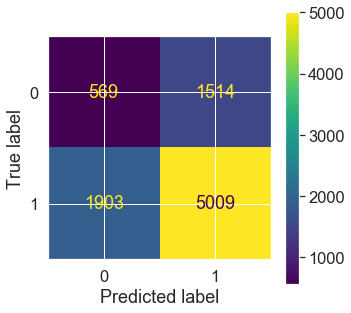

In [18]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbmodel,X,result1,values_format='.4g',ax=ax)
plt.show()

In [19]:
print(classification_report(y,result1))

              precision    recall  f1-score   support

           0       0.45      0.23      0.30      4065
           1       0.55      0.77      0.64      4930

    accuracy                           0.52      8995
   macro avg       0.50      0.50      0.47      8995
weighted avg       0.50      0.52      0.49      8995



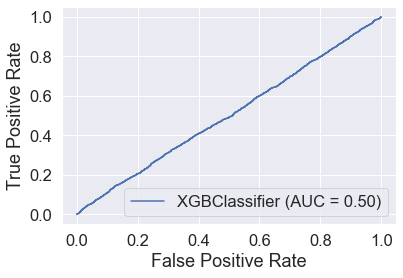

In [20]:
plot_roc_curve(xgbmodel,X,result1)
plt.show()

### Cross-Validation

In [21]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [22]:
cv.mean()

0.5750972762645914